# Bounding box matching
This notebook discusses how to customize how annotations and detections are matched when computing statistics.


<div class="alert alert-info">

**Note:**  
While this tutorial primarily shows its usage with PR functions, these methods apply to all statistics that are available in brambox.

</div>

In [1]:
# Basic imports
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import brambox as bb

# Settings
sns.set_theme(style='ticks', context='notebook')

We will be using the same data as the [Getting Started](../notes/02-getting_started.ipynb#Loading-data) guide,
so check that one out for more information.

In [2]:
# Load data
det = bb.io.load('pandas', 'detections.h5')
anno = bb.io.load('pandas', 'annotations.h5')

## Ignoring annotations
Sometimes when computing statistics, you can have some objects that are quite difficult to find for your detector.
You can thus decide you want to ignore these annotations, by using the boolean `ignore` column of your dataset.

The pickle files we use already contain some ignored bounding boxes, but most formats will not include such ignore meta-data about your ground truth bounding boxes, resulting in the `ignore` column to be **False** for every box. It is up to you to compute which bounding box to ignore, by looking at eg. the `difficult` or the `occluded` values.

In [3]:
# Show ignored annotations
display(anno[anno.ignore].head())

image class_label  x_top_left  y_top_left  width  \
13  VOC2007/JPEGImages/000006       chair       137.0       198.0   20.0   
14  VOC2007/JPEGImages/000006       chair       137.0       192.0   15.0   
15  VOC2007/JPEGImages/000006       chair       279.0       190.0   30.0   
19  VOC2007/JPEGImages/000006       chair       298.0       195.0   35.0   
26  VOC2007/JPEGImages/000014         car       163.0       197.0  105.0   

    height  ignore  
13    15.0    True  
14     8.0    True  
15    42.0    True  
19    53.0    True  
26    48.0    True

Once you computed `ignored` annotations, the statistical functions in brambox will use them by default.  
Here we will show you an example with the [pr()](../api/generated/brambox.stat.pr.rst) function.

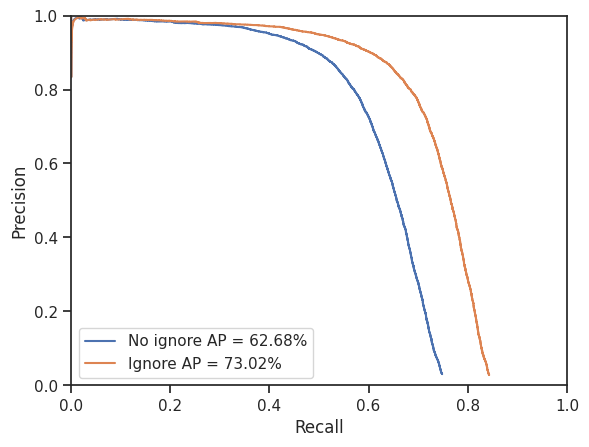

In [4]:
# PR function without ignored annotations
pr_noignore = bb.stat.pr(det, anno, ignore=False)
ap_noignore = bb.stat.ap(pr_noignore)

# PR function, whilst considering ignored annotations as regions (see PR documentation)
pr_ignore = bb.stat.pr(det, anno)
ap_ignore = bb.stat.ap(pr_ignore)

# Plot both PR functions to show difference
ax = pr_noignore.plot(
    'recall', 'precision',
    drawstyle='steps', label=f'No ignore AP = {round(100*ap_noignore, 2)}%'
)
pr_ignore.plot(
    'recall', 'precision',
    drawstyle='steps', label=f'Ignore AP = {round(100*ap_ignore, 2)}%',
    ax=ax
)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

By default brambox will handle `ignored` annotations in the following way, which coincides with how the Piotr Dollar matlab toolbox computes PR functions:

1. We try to match a detection with non-ignored annotations by using the [IoU()](../api/generated/brambox.stat.coordinates.iou.rst) metric.
2. Failing that, we try to match with ignored annotations by using the [IoA()](../api/generated/brambox.stat.coordinates.ioa.rst) metric.
3. Multiple detections can be matched with the same ignored annotations.

This effectively means that `ignored` annotations are considered as a region,
where any detection that lies inside of the region (IoA) will be ignored if it fails to find a matching annotation.

While a lot of datasets have some kind of `ignore` property, they all have different guidelines how to handle them.
You will learn how to completely customize the ignored matching behavior in the next part of this tutorial.

## Custom matching function
Before looking into modifying how brambox handles the `ignored` annotations, we need to understand how brambox computes statistics.
Most brambox statistical functions start by matching detections and annotations according to some metric (eg. IoU).  
To do this, brambox uses the [match_anno()](../api/generated/brambox.stat.match_anno.rst), [match_det()](../api/generated/brambox.stat.match_det.rst) or [match_box()](../api/generated/brambox.stat.match_box.rst) functions.  
All three functions perform the same thing (matching annotations and detections), but the difference lies in their return values, being a modified annotation _(extra detection index and criteria value column)_, detection _(extra TP/FP columns)_ dataframe or both respectively. Take a look at the documentation of those functions for more information on their return values.

Any statistical function that needs matching will first check if the passed annotations and detections have already been matched, by looking if the extra columns already exist on the dataframe(s).
This allows a user to easily modify the matching behavior by calling the correct matching function before the statistic.
Check the documentation of the statistical function you want to use (eg. pr, mrfppi, ...) to know whether it uses [match_anno()](../api/generated/brambox.stat.match_anno.rst), [match_det()](../api/generated/brambox.stat.match_det.rst) or [match_box()](../api/generated/brambox.stat.match_box.rst).

In the following example, we modify the matching behavior for ignored annotations, by only allowing to match with an `ignored` annotation once, and using the [IoU()](../api/generated/brambox.stat.coordinates.iou.rst) metric for all matching. This effectively means that ignored annotations are considered as regular annotations, but we just don't care whether a detection is found that matches that annotation.

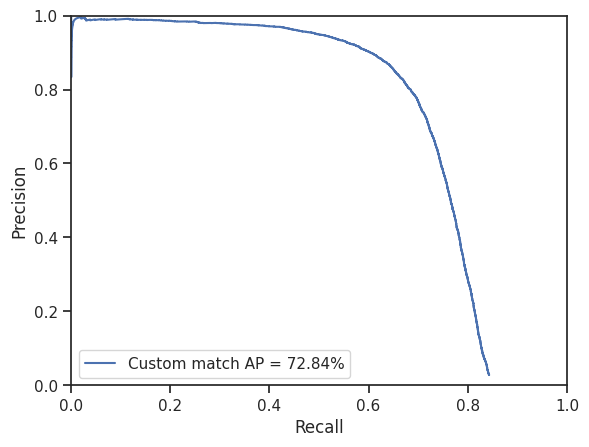

In [5]:
# Custom matching: PR matches boxes by using the match_det function (see PR documentation)
matched_det = bb.stat.match_det(
    det, anno,
    threshold=0.5,                       # Matching threshold (Here IoU, see matching function)
    criteria=bb.stat.coordinates.iou,    # Matching function
    ignore=bb.stat.IgnoreMethod.SINGLE,  # Only allow to match with ignored anno once
)

# Compute PR with custom matched detection
pr = bb.stat.pr(matched_det, anno)
ap = bb.stat.ap(pr)

ax = pr_ignore.plot('recall', 'precision', drawstyle='steps', label=f'Custom match AP = {round(100*ap, 2)}%')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

This is just an example of what you can do with custom matching functions.
By providing a custom criteria function, you could take the `id` of bounding boxes into account and perform some kind of _detection+re-identification_ metric.  
What's more, by pairing this with custom parsers that allow you to add any property of your annotations/detections as an extra column to your dataframe, the possibilities for custom statistics are endless. Head over to the next tutorial to learn all about these custom parsers!